# Trawl processes simulations

In [1]:
from scipy.stats import levy_stable
import matplotlib.pyplot as plt
import numpy as np

The matrix `F` has shape (u-dim, k-dim, timesteps)

In [2]:
N = 300 # grid size
n = 100 # number of timesteps
M = 4 * N # extended grid size

gamma = 0.3
alpha = 1.9


The Hurst exponent $H$ equals:

In [3]:
(alpha-gamma)/alpha

0.8421052631578947

In [21]:
class: TrawlProcess:
    def __init__(self, alpha, gamma, N=300, n=100, M=4*N):
        self.H = (alpha-gamma)/alpha
        self.alpha = alpha
        self.gamma = gamma
    
    def sample_paths(self, num_paths=1):
        
    def _calculate_f(self)
   

SyntaxError: invalid syntax (<ipython-input-21-7af74b7aa226>, line 1)

In [4]:
M*M*n

144000000

In [5]:
mask = np.ones((6, 6), dtype=int)
mask

array([[1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1]])

In [6]:
mask1 = np.triu(mask, 0)
mask1

array([[1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 1]])

In [7]:
mask1[4,4]

1

In [8]:
mask3 = np.triu(mask, -2)
mask3

array([[1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1]])

In [9]:
mask2 = np.zeros((6, 6), dtype=bool)
mask2[:, 0:3] = 1
mask2

array([[ True,  True,  True, False, False, False],
       [ True,  True,  True, False, False, False],
       [ True,  True,  True, False, False, False],
       [ True,  True,  True, False, False, False],
       [ True,  True,  True, False, False, False],
       [ True,  True,  True, False, False, False]])

In [10]:
mask1*mask2

array([[1, 1, 1, 0, 0, 0],
       [0, 1, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [11]:
~mask2

array([[False, False, False,  True,  True,  True],
       [False, False, False,  True,  True,  True],
       [False, False, False,  True,  True,  True],
       [False, False, False,  True,  True,  True],
       [False, False, False,  True,  True,  True],
       [False, False, False,  True,  True,  True]])

In [12]:
A = np.array(range(6))
A = A.reshape(1, -1)
B = np.ones((6, 1))
#B = B.reshape(-1,1)
C =B @ A
D = C.T

In [13]:
C - D

array([[ 0.,  1.,  2.,  3.,  4.,  5.],
       [-1.,  0.,  1.,  2.,  3.,  4.],
       [-2., -1.,  0.,  1.,  2.,  3.],
       [-3., -2., -1.,  0.,  1.,  2.],
       [-4., -3., -2., -1.,  0.,  1.],
       [-5., -4., -3., -2., -1.,  0.]])

In [14]:
from numba import jit

In [15]:
%%time

@jit()
def calculate_f():
    F = np.zeros((M, M, n), dtype=np.float32)
    for timestep in range(n):
        # (K, J)
        mask1 =np.triu(np.ones((M, M), dtype=np.bool)) # J >= K
    
        mask2 = np.zeros((M, M),  dtype=np.bool)
        mask2[0: timestep*(N//n), :] = True # K < timestep * (N/n)
        mask3 = np.triu(np.ones((M, M), dtype=np.bool), -timestep*(N//n)) # K - timestep (N/n) <= J
        f = np.zeros((N,N), dtype=np.float64)
    
        m1 = mask1*mask2
        f1 = np.zeros((M,M), dtype=np.float64)
        # Get a matrix A1 with column values
        A = np.array(range(M))
        A = A.reshape(1,-1)
        B = np.ones((M,1))
        A1 = (B @ A) # A1.T[k,j] = k
        f1 = A1.T * m1
    
        m2 = (~mask1) * mask2 # J < K and 0 <= k < timestep* N/n
        f2 = m2 * A1 
    
        m3 = mask1 * (~mask2)
        f3 = m3 * timestep*(N//n)
    
        m4 = (~mask1) * (~mask2) * mask3
        f4 = (timestep * (N//n) + A1 - A1.T) * m4
        f = f1 + f2 + f3 + f4
        #print(f.shape)
        F[:, :, timestep] = f
        
    F = F.reshape(n, M, M)
    return F

F = calculate_f()


CPU times: user 17.6 s, sys: 19.9 s, total: 37.5 s
Wall time: 11.6 s


In [16]:
S = np.zeros((M, M), dtype=np.float64)
for J in range(M):
    if J != 0:
        S[:, J] = (1./(N**(2+gamma)*(1+gamma))) * (J**(-1-gamma) - (J+1)**(-1-gamma))

`S` is the matrix of scale factors

### Simulate stable random variables

In [17]:
@jit()
def calculate_paths(num_paths=1):
    stable_dist = levy_stable(alpha, 0.)
    draw = stable_dist.rvs(size=(num_paths, M, M))
    samples = draw * np.power(S, 1./alpha)
    samples = samples.reshape(-1, 1, M, M)
    time_samples =  samples * F
    return np.sum(time_samples, axis=(2,3))

In [18]:
%%time
paths = calculate_paths(num_paths=4)

CPU times: user 4.16 s, sys: 2.39 s, total: 6.55 s
Wall time: 6.55 s


In [19]:
paths.shape

(4, 100)

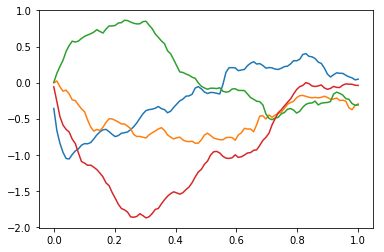

In [20]:
for path in range(paths.shape[0]):
    plt.plot(np.linspace(0,1, n), paths[path])
plt.show()